# RT-HF with Density Matrix

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf_interface import *
import tikzplotlib

π = np.pi
α = 0.007297352
c = 1.0/α
np.set_printoptions(precision=4, linewidth=200, threshold=2000, suppress=True)

### Let's intialize the molecules

In [2]:
### Hydrogen cyanide / HCN
Z_HCN = np.array(["N", "C", "H"])
R_HCN = np.array([[-0.5800,    0.0000,    0.0000], [ 0.5800,    0.0000,    0.0000], [ 1.6450,    0.0000,    0.0000]])

### Hydroxide (OH)
Z_OH = np.array(["O", "H"])
R_OH = np.array([[ 0., 0., 3.], [0., 0., 2.]])

OH = pyscf_UHF()
OH.initialize(xyz=R_HCN, Z=Z_HCN, charge=0, basis="sto-3g")
OH.Calc()

OH = pyscf_UHF()
OH.initialize(xyz=R_OH, Z=Z_OH, charge=0, basis="sto-3g")
OH.Calc()

### Next lets initialize the field

In [3]:
field3 = E_field()
field3.E0 = 1e-5
field3.ω  = 0.25
field3.Γ  = 1.
field3.vector = np.array([1.,1.,1.])

### Control

100%|██████████| 10000/10000 [00:02<00:00, 3518.97it/s]


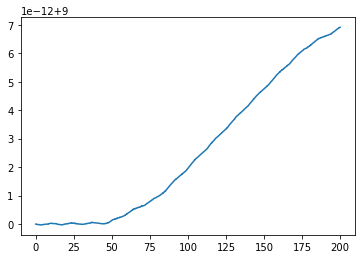

In [36]:
uhf_object = OH

dt = 0.02
t = np.arange(0, 200, dt)
trace = np.zeros(10000)
DA_mo = uhf_object.Da_mo
DB_mo = uhf_object.Db_mo

ddd = np.zeros(10000)
for i in tqdm(range(10000)):
    
    Da_ao, Db_ao = uhf_object.getAO(DA_mo, DB_mo)
    FA_ao, FB_ao = uhf_object.get_UCFock(Da_ao, Db_ao) - 0.*np.random.random(DA_mo.shape)
    ddd[i]  = np.einsum('xAB, AB -> x', uhf_object.D, ( Da_ao + Db_ao ).real )[0]
    Fa_mo, Fb_mo = uhf_object.getMO(FA_ao, FB_ao)
    UA = Expm(- 1j * Fa_mo * dt)
    UB = Expm(- 1j * Fb_mo * dt)
    
    DA_mo = UA @ DA_mo @ ((UA).conj().T)
    DB_mo = UB @ DB_mo @ ((UB).conj().T)
    
    trace[i] = np.trace(DA_mo + DB_mo).real
    
plt.plot(t, trace)
plt.show()

100%|██████████| 10000/10000 [00:02<00:00, 3509.11it/s]


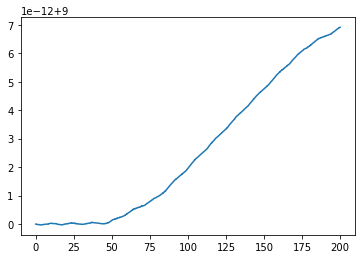

In [38]:
def UT_obj(uhf_object):
    
    dt = 0.02
    t = np.arange(0, 200, dt)
    trace = np.zeros(10000)
    DA_mo = uhf_object.Da_mo
    DB_mo = uhf_object.Db_mo

    ddd = np.zeros(10000)
    for i in tqdm(range(10000)):

        Da_ao, Db_ao = uhf_object.getAO(DA_mo, DB_mo)
        FA_ao, FB_ao = uhf_object.get_UCFock(Da_ao, Db_ao) - 0.*np.random.random(DA_mo.shape)
        ddd[i]  = np.einsum('xAB, AB -> x', uhf_object.D, ( Da_ao + Db_ao ).real )[0]
        Fa_mo, Fb_mo = uhf_object.getMO(FA_ao, FB_ao)
        UA = Expm(- 1j * Fa_mo * dt)
        UB = Expm(- 1j * Fb_mo * dt)

        DA_mo = UA @ DA_mo @ ((UA).conj().T)
        DB_mo = UB @ DB_mo @ ((UB).conj().T)

        trace[i] = np.trace(DA_mo + DB_mo).real
    
    return t, ddd, trace

tt, dx, tr = UT_obj(OH)

plt.plot(t, trace)
plt.show()

### UT Integration Scheme

In [10]:
def RTHF_UT(uhf_object, DA_t=None, DB_t=None, dt = 0.002, dT = 100, onoff=1.0, field=None, MD=False, Current=False, probe=False):
    tsteps = int(dT/dt)
    
    if DA_t is None:
        DA_t = 1.*(uhf_object.Da_mo)
    if DB_t is None:
        DB_t = 1.*(uhf_object.Db_mo)
    if field is None:
        field = E_field()
        field.E0 = 0.
        field.Γ  = 100.
    
    if probe:
        energy = np.zeros(tsteps)
        trace  = np.zeros(tsteps)
    d_tx   = np.zeros((tsteps, 3))
    for step in tqdm(range(tsteps)):
        t = (step) * dt
        
        DA_ao, DB_ao = uhf_object.getAO(DA_t, DB_t)
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        FA, FB = uhf_object.getMO(FA_ao, FB_ao)
        
        #### probe
        d_tx[step]  = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        if probe:
            trace[step]  = np.trace(DA_t.real + DB_t.real)
            energy[step] = uhf_object.get_Euhf(DA_ao, DB_ao, FA_ao, FB_ao).real
        ####
        
        # compute propagators
        UA  = Expm( -1j*(dt)*FA )
        UB  = Expm( -1j*(dt)*FB )
        #Unit[step] = np.abs(np.einsum("pq -> ", UA @ (UA.conj().T) - np.eye(len(UA)).astype(complex) ))
        
        ### full step forward
        DA_t  = (UA) @ DA_t @ ((UA).conj().T)
        DB_t  = (UB) @ DB_t @ ((UB).conj().T)
        
    
    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    
    if probe:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, trace, energy
    else:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx

### MMUT Integration Scheme

In [11]:
def RTHF_MMUT(uhf_object, DA_t=None, DB_t=None, dt = 0.002, dT = 1000, onoff=1.0, field=None, MD=False, Current=False, probe=False):
    
    tsteps = int(dT/dt)
    
    if DA_t is None:
        DA_t = 1.*uhf_object.Da_mo
    if DB_t is None:
        DB_t = 1.*uhf_object.Db_mo
    if field is None:
        def field(t):
            return np.zeros(3)
    
    ### compute initial half step propagators?
    DA_ao   = ( uhf_object.Ca ) @ DA_t @ ( (uhf_object.Ca).T)
    DB_ao   = ( uhf_object.Cb ) @ DB_t @ ( (uhf_object.Cb).T)
    FA_ao, FB_ao = uhf_object.get_UFock(DA_ao, DB_ao)
    FA0_mo  = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca)
    FB0_mo  = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
    UA_half = Expm( -1j*FA0_mo*dt/2 ) #!!!
    UB_half = Expm( -1j*FB0_mo*dt/2 ) #!!!
    DA_half = (UA_half.conj().T) @ DA_t @ (UA_half)
    DB_half = (UB_half.conj().T) @ DB_t @ (UB_half)
    
    if MD:
        f_ix = np.zeros(uhf_object.dS.shape)
    if Current:
        J = np.zeros((tsteps, 2, len(uhf_object.Da_mo), len(uhf_object.Da_mo)), dtype=complex)
    if probe:
        energy = np.zeros(tsteps)
        trace  = np.zeros(tsteps)
    d_tx = np.zeros((tsteps, 3))
    for step in tqdm(range(tsteps)):
        t = step * dt
    
        # get AO density matrices
        DA_ao = ( uhf_object.Ca ) @ DA_t @ ( (uhf_object.Ca).T)
        DB_ao = ( uhf_object.Cb ) @ DB_t @ ( (uhf_object.Cb).T)
    
        # compute FA_t, FB_t
        FA_ao, FB_ao = uhf_object.get_UFock(DA_ao, DB_ao) - onoff * np.einsum('xmn, x -> mn', uhf_object.D, field.getEE(t) )
        
        # save to stuff
        d_tx[step] = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        if Current:
            J[step, 0] = DA_t
            J[step, 1] = DB_t
        if probe:
            trace[step] = np.einsum("ii -> ", DA_t + DB_t).real
            energy[step] = uhf_object.get_Euhf(DA_ao, DB_ao, FA_ao, FB_ao).real
        if MD:
            f_ix += uhf_object.get_force(DA_ao, DB_ao, FA_ao, FB_ao)
        
        FA = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca)
        FB = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        
        # compute propagators
        UA_half = Expm( -1j*FA*dt ) #!!!
        UB_half = Expm( -1j*FB*dt ) #!!!
        
        # half step forward
        DA_half = (UA_half) @ DA_half @ (UA_half.conj().T)
        DB_half = (UB_half) @ DB_half @ (UB_half.conj().T)
        
        # get AO density matrices
        DA_ao = ( uhf_object.Ca ) @ DA_half @ ( (uhf_object.Ca).T)
        DB_ao = ( uhf_object.Cb ) @ DB_half @ ( (uhf_object.Cb).T)
        
        # compute FA_t, FB_t
        t = (step + 0.5) * dt
        FA_ao, FB_ao = uhf_object.get_UFock(DA_ao, DB_ao) - onoff * np.einsum('xmn, x -> mn', uhf_object.D, field.getEE(t) )
        FA = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca)
        FB = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        
        # compute propagators
        UA  = Expm( -1j*FA*dt ) #!!!
        UB  = Expm( -1j*FB*dt ) #!!!        
        
        # full step forward
        DA_t = (UA) @ DA_t @ (UA.conj().T)
        DB_t = (UB) @ DB_t @ (UB.conj().T)
    
    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    
    if MD:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, f_ix, DA_t, DB_t
    if probe:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, trace, energy
    if Current:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, J
    else:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx

### RK4 Integration Scheme

In [8]:
def RTHF_RK4(uhf_object, DA_t=None, DB_t=None, dt = 0.002, dT = 100, onoff=1.0, field=None, MD=False, Current=False, probe=False):
    """ With Electric Dipole Interaction """
    """
    DA_t, DB_t = Initial MO Density (2d np.array)
    CA_T, CB_T = Coefficients in dT (2d np.array)
    dt     = Electronic Time Step (float)
    dT     = # of Electronic Time Steps (int)
    onoff  = Number to turn: off = 0 & on = 1 interaction (float)
    dipole = dipole integral in given direction (2d np.array)
    """
    tsteps = int(dT/dt)
    
    if DA_t is None:
        DA_t = 1.*(uhf_object.Da_mo)
    if DB_t is None:
        DB_t = 1.*(uhf_object.Db_mo)
    if field is None:
        field = E_field()
        field.E0 = 0.
        field.Γ  = 100.
        
    #time  = np.linspace(0, dT, int(dT/dt), endpoint=False)
    if MD:
        f_ix = np.zeros(uhf_object.dS.shape)
    if Current:
        J = np.zeros((tsteps, 2, len(uhf_object.Da_mo), len(uhf_object.Da_mo)), dtype=complex)
    if probe:
        energy = np.zeros(tsteps)
        trace  = np.zeros(tsteps)
        
    time = np.linspace(0, dt*dT, dT, endpoint=False)
    d_tx = np.zeros((tsteps, 3))
    for step in tqdm(range(tsteps)):
        # =============================================================================
        # Runge-Kutta 4th Order Integrator
        # =============================================================================
        # compute K1
        t = (step + 0.0) * dt
        # =============================================================================
        DA_ao = (uhf_object.Ca) @ DA_t @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ DB_t @ (uhf_object.Cb).T
        d_tx[step]  = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        
        if Current:
            J[step, 0] = DA_t
            J[step, 1] = DB_t
        if probe:
            trace[step] = np.einsum("ii -> ", DA_t + DB_t).real
            energy[step] = uhf_object.get_Euhf(DA_ao, DB_ao, FA_ao, FB_ao).real
        if MD:
            f_ix += uhf_object.get_force(DA_ao, DB_ao, FA_ao, FB_ao)
        
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K1_αe = -1j*(F_t_αe@DA_t - DA_t@F_t_αe)
        K1_βe = -1j*(F_t_βe@DB_t - DB_t@F_t_βe)
        
        tempD_αe = DA_t + 0.5 * dt * K1_αe
        tempD_βe = DB_t + 0.5 * dt * K1_βe
        
        
        # compute K2
        t = (step + 0.5) * dt
        DA_ao = (uhf_object.Ca) @ tempD_αe @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ tempD_βe @ (uhf_object.Cb).T
        # =============================================================================
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K2_αe = -1j*(F_t_αe@tempD_αe - tempD_αe@F_t_αe)
        K2_βe = -1j*(F_t_βe@tempD_βe - tempD_βe@F_t_βe)
        
        tempD_αe = DA_t + 0.5 * dt * K2_αe
        tempD_βe = DB_t + 0.5 * dt * K2_βe
        
        
        # compute K3
        DA_ao = (uhf_object.Ca) @ tempD_αe @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ tempD_βe @ (uhf_object.Cb).T
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K3_αe = -1j*(F_t_αe@tempD_αe - tempD_αe@F_t_αe)
        K3_βe = -1j*(F_t_βe@tempD_βe - tempD_βe@F_t_βe)
        
        tempD_αe = DA_t + 1.0 * dt * K3_αe
        tempD_βe = DB_t + 1.0 * dt * K3_βe
        
        
        # compute K4
        t = (step + 1.0) * dt
        DA_ao = (uhf_object.Ca) @ tempD_αe @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ tempD_βe @ (uhf_object.Cb).T
        # =============================================================================
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K4_αe = -1j*(F_t_αe@tempD_αe - tempD_αe@F_t_αe)
        K4_βe = -1j*(F_t_βe@tempD_βe - tempD_βe@F_t_βe)
        
        DA_t += (dt/6.0) * (K1_αe + 2.0 * K2_αe + 2.0 * K3_αe + K4_αe) 
        DB_t += (dt/6.0) * (K1_βe + 2.0 * K2_βe + 2.0 * K3_βe + K4_βe)
        
        
        # =============================================================================
        # Output MO Currents
        # =============================================================================

    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    
    if MD:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, f_ix, DA_t, DB_t
    if probe:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, trace, energy
    else:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx

### RK2 Integration Scheme

In [7]:
def RTHF_RK2(uhf_object, DA_t=None, DB_t=None, dt = 0.002, dT = 100, onoff=1.0, field=None, MD=False, Current=False, probe=False):
    """ With Electric Dipole Interaction """
    """
    DA_t, DB_t = Initial MO Density (2d np.array)
    CA_T, CB_T = Coefficients in dT (2d np.array)
    dt     = Electronic Time Step (float)
    dT     = # of Electronic Time Steps (int)
    onoff  = Number to turn: off = 0 & on = 1 interaction (float)
    dipole = dipole integral in given direction (2d np.array)
    """
    tsteps = int(dT/dt)
    
    if DA_t is None:
        DA_t = 1.*(uhf_object.Da_mo)
    if DB_t is None:
        DB_t = 1.*(uhf_object.Db_mo)
    if field is None:
        field = E_field()
        field.E0 = 0.
        field.Γ  = 100.
    
    if MD:
        f_ix = np.zeros(uhf_object.dS.shape)
    if Current:
        J = np.zeros((tsteps, 2, len(uhf_object.Da_mo), len(uhf_object.Da_mo)), dtype=complex)
    if probe:
        energy = np.zeros(tsteps)
        trace  = np.zeros(tsteps)
    d_tx = np.zeros((tsteps, 3))
    time = np.linspace(0, dt*dT, dT, endpoint=False)
    for step in tqdm(range(tsteps)):
        # =============================================================================
        # Runge-Kutta 2nd Order Integrator
        # =============================================================================
        # compute K1
        t = (step + 0.0) * dt
        # =============================================================================
        DA_ao = (uhf_object.Ca) @ DA_t @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ DB_t @ (uhf_object.Cb).T
        d_tx[step] = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        
        if Current:
            J[step, 0] = DA_t
            J[step, 1] = DB_t
        if probe:
            trace[step] = np.einsum("ii -> ", DA_t + DB_t).real
            energy[step] = uhf_object.get_Euhf(DA_ao, DB_ao, FA_ao, FB_ao).real
        if MD:
            f_ix += uhf_object.get_force(DA_ao, DB_ao, FA_ao, FB_ao)
        
        
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K1A = -1j*(F_t_αe@DA_t - DA_t@F_t_αe) * dt
        K1B = -1j*(F_t_βe@DB_t - DB_t@F_t_βe) * dt
        
        tempD_αe = DA_t + K1A
        tempD_βe = DB_t + K1B
        
        
        # compute K2
        t = (step + 1.0) * dt
        DA_ao = (uhf_object.Ca) @ tempD_αe @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ tempD_βe @ (uhf_object.Cb).T
        # =============================================================================
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K2A = -1j*(F_t_αe@tempD_αe - tempD_αe@F_t_αe) * dt
        K2B = -1j*(F_t_βe@tempD_βe - tempD_βe@F_t_βe) * dt
        
        DA_t += (1/2.) * (K1A + K2A) 
        DB_t += (1/2.) * (K1B + K2B)
        
        
        # =============================================================================
        # Output MO Currents
        # =============================================================================

    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    if MD:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, f_ix/tsteps, DA_t, DB_t
    if probe:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, trace, energy
    if Current:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, J
    else:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx

### RKMK4 Integration Scheme

In [5]:
def RTHF_RKMK4(uhf_object, DA_t=None, DB_t=None, dt = 0.002, dT = 100, onoff=1.0, field=None, MD=False, Current=False, probe=False):
    """ With Electric Dipole Interaction """
    """
    DA_t, DB_t = Initial MO Density (2d np.array)
    CA_T, CB_T = Coefficients in dT (2d np.array)
    dt     = Electronic Time Step (float)
    dT     = # of Electronic Time Steps (int)
    onoff  = Number to turn: off = 0 & on = 1 interaction (float)
    dipole = dipole integral in given direction (2d np.array)
    """
    tsteps = int(dT/dt)
    
    if DA_t is None:
        DA_t = 1.*(uhf_object.Da_mo)
    if DB_t is None:
        DB_t = 1.*(uhf_object.Db_mo)
    if field is None:
        field = E_field()
        field.E0 = 0.
        field.Γ  = 100.
    #time  = np.linspace(0, dT, int(dT/dt), endpoint=False)
    if MD:
        f_ix = np.zeros(uhf_object.dS.shape)
    if Current:
        J = np.zeros((tsteps, 2, len(uhf_object.Da_mo), len(uhf_object.Da_mo)), dtype=complex)
    if probe:
        energy = np.zeros(tsteps)
        trace  = np.zeros(tsteps)
    d_tx = np.zeros((tsteps, 3))
    time   = np.linspace(0, dt*dT, dT, endpoint=False)
    for step in tqdm(range(tsteps)):
        # =============================================================================
        # Runge-Kutta MK 4th Order Integrator
        # =============================================================================
        # compute K1
        t = (step + 0.0) * dt
        # =============================================================================
        DA_ao = (uhf_object.Ca) @ DA_t @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ DB_t @ (uhf_object.Cb).T
        
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        
        d_tx[step]   = np.einsum('xAB, AB -> x', uhf_object.D, ( DA_ao + DB_ao ).real )
        if Current:
            J[step, 0] = DA_t
            J[step, 1] = DB_t
        if probe:
            trace[step] = np.einsum("ii -> ", DA_t + DB_t).real
            energy[step] = uhf_object.get_Euhf(DA_ao, DB_ao, FA_ao, FB_ao).real
        if MD:
            f_ix += uhf_object.get_force(DA_ao, DB_ao, FA_ao, FB_ao)
            
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K1A = -1j*(F_t_αe@DA_t - DA_t@F_t_αe) * dt
        K1B = -1j*(F_t_βe@DB_t - DB_t@F_t_βe) * dt
        
        P2A = Expm(0.5* K1A) @ DA_t
        P2B = Expm(0.5* K1B) @ DB_t
        
        # compute K2
        t = (step + 0.5) * dt
        DA_ao = (uhf_object.Ca) @ P2A @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ P2B @ (uhf_object.Cb).T
        # =============================================================================
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K2A = -1j*(F_t_αe@P2A - P2A@F_t_αe) * dt
        K2B = -1j*(F_t_βe@P2B - P2B@F_t_βe) * dt
        
        P3A = Expm(0.5* K2A - 0.125* (K1A @ K2A - K2A @ K1A) ) @ DA_t
        P3B = Expm(0.5* K2B - 0.125* (K1B @ K2B - K2B @ K1B) ) @ DB_t
        
        
        # compute K3
        DA_ao = (uhf_object.Ca) @ P3A @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ P3B @ (uhf_object.Cb).T
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K3A = -1j*(F_t_αe@P3A - P3A@F_t_αe) * dt
        K3B = -1j*(F_t_βe@P3B - P3B@F_t_βe) * dt
        
        P4A = Expm(K3A) @ DA_t
        P4B = Expm(K3B) @ DB_t
        
        
        # compute K4
        t = (step + 1.0) * dt
        DA_ao = (uhf_object.Ca) @ P4A @ (uhf_object.Ca).T
        DB_ao = (uhf_object.Cb) @ P4B @ (uhf_object.Cb).T
        # =============================================================================
        FA_ao, FB_ao = uhf_object.get_UCFock(DA_ao, DB_ao) - onoff * np.einsum('xAB, x -> AB', uhf_object.D, field.getEE(t) )
        F_t_αe = ((uhf_object.Ca).T) @ FA_ao @ (uhf_object.Ca) 
        F_t_βe = ((uhf_object.Cb).T) @ FB_ao @ (uhf_object.Cb)
        K4A = -1j*(F_t_αe@P4A - P4A@F_t_αe) * dt
        K4B = -1j*(F_t_βe@P4B - P4B@F_t_βe) * dt
        
        DA_t = Expm( (1/6.) * (K1A + 2.*K2A + 2.*K3A + K4A - 0.5*(K1A @ K4A - K4A @ K1A) ) ) @ DA_t
        DB_t = Expm( (1/6.) * (K1B + 2.*K2B + 2.*K3B + K4B - 0.5*(K1B @ K4B - K4B @ K1B) ) ) @ DB_t
        
        
        # =============================================================================
        # Output MO Currents
        # =============================================================================

    d_tx -= np.einsum("tx -> x", d_tx)/len(d_tx)
    if MD:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, f_ix, DA_t, DB_t
    if probe:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, trace, energy
    if Current:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx, J
    else:
        return np.linspace(0, dt*tsteps, tsteps, endpoint=False), d_tx

## Results
##### MO Density Matrix Trace: trace
##### Energy Conversation: energy
##### Spectra (+LR)

In [12]:
t, d_rk4, tr_rk4, E_rk4 = RTHF_RK4(OH, dt = 0.002, dT =1000, field=field3, probe=True)

100%|██████████| 500000/500000 [06:38<00:00, 1255.40it/s]


In [13]:
t, d_ut, tr_ut, E_ut = RTHF_UT(OH, dt = 0.002, dT =1000, field=field3, probe=True)

100%|██████████| 500000/500000 [02:35<00:00, 3212.29it/s]


In [14]:
t, d_rk2, tr_rk2, E_rk2 = RTHF_RK2(OH, dt = 0.002, dT =1000, field=field3, probe=True)

100%|██████████| 500000/500000 [03:25<00:00, 2434.09it/s]


In [15]:
t, d_mmut, tr_mmut, E_mmut = RTHF_MMUT(OH, dt = 0.002, dT =1000, field=field3, probe=True)

100%|██████████| 500000/500000 [05:01<00:00, 1659.62it/s]


In [16]:
t, d_rkmk4, tr_rkmk4, E_rkmk4 = RTHF_RKMK4(OH, dt = 0.002, dT =1000, field=field3, probe=True)

100%|██████████| 500000/500000 [10:26<00:00, 798.00it/s]


### Let's Calculate the LR for checking later...

In [18]:
OH.UCIS()
OH.UTDHF_calc()
ω_LR = OH.TDHF_E[:-1]
f_LR = OH.TDHF_f[:-1]

def LorentzianA(ω, ω0, f, Γ):
    ω = (ω + 1j*Γ)**2
    
    ww0 = np.einsum("w, v -> wv", ω, np.ones(ω0.shape)) - np.einsum("v,w -> wv", ω0**2, np.ones(ω.shape))
    return np.einsum("v, wv -> w", -f, 1/(ww0) )

α_ω = LorentzianA(ω, ω_LR, f_LR, 0.01)

### Finaly Let's plot results

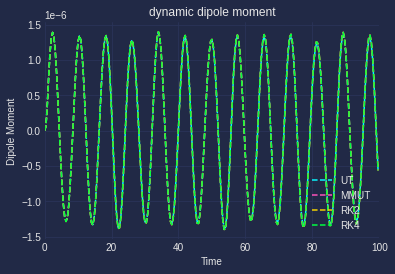

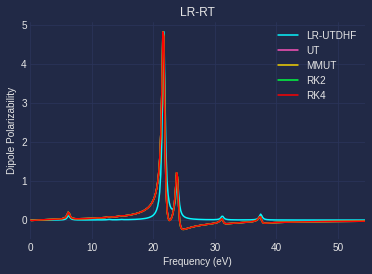

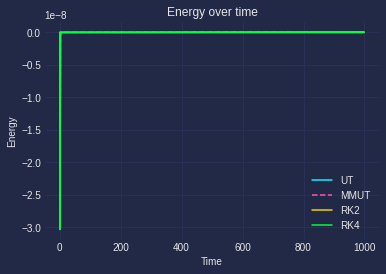

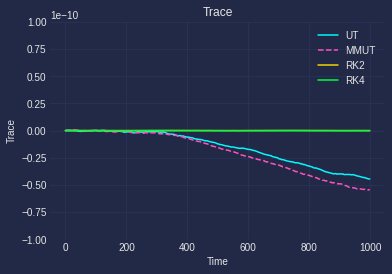

In [24]:
import mplcyberpunk
plt.style.use("cyberpunk")

plt.plot(t[:50000][::200], d_ut[:50000][::200,2], label="UT", linestyle="dashed")
plt.plot(t[:50000][::200], d_mmut[:50000][::200,2], label="MMUT", linestyle="dashed")
plt.plot(t[:50000][::200], d_rk2[:50000][::200,2], label="RK2", linestyle="dashed")
plt.plot(t[:50000][::200], d_rk4[:50000][::200,2], label="RK4", linestyle="dashed")
#plt.plot(t[::10], d_rkmk4[::10,2], label="RKMK4")
plt.xlim([0,100])
plt.legend(loc='lower right')
plt.xlabel("Time")
plt.ylabel("Dipole Moment")
plt.title("dynamic dipole moment")
tikzplotlib.save("dipole_methods.tex")
plt.show()

ω, dω_ut    = RT_FFT(t,    d_ut, Γ=0.01)
ω, dω_mmut  = RT_FFT(t,  d_mmut, Γ=0.01)
ω, dω_rk2   = RT_FFT(t,   d_rk2, Γ=0.01)
ω, dω_rk4   = RT_FFT(t,   d_rk4, Γ=0.01)
ω, dω_rkmk4 = RT_FFT(t, d_rkmk4, Γ=0.01)
plt.plot(27.21138*ω[:1000], α_ω.imag[:1000]/(4*np.pi), label="LR-UTDHF")
plt.plot(27.21138*ω[:1000], -np.einsum("wx -> w",    dω_ut.imag/field3.E0)[:1000], label="UT")
plt.plot(27.21138*ω[:1000], -np.einsum("wx -> w",  dω_mmut.imag/field3.E0)[:1000], label="MMUT")
plt.plot(27.21138*ω[:1000], -np.einsum("wx -> w",   dω_rk2.imag/field3.E0)[:1000], label="RK2")
plt.plot(27.21138*ω[:1000], -np.einsum("wx -> w",   dω_rk4.imag/field3.E0)[:1000], label="RK4")
#plt.plot(ω[:1000], -np.einsum("wx -> w", dω_rkmk4.imag/field3.E0)[:1000], label="RKMK4")
plt.xlim([0,2*27.21138])
plt.legend()
plt.xlabel("Frequency (eV)")
plt.ylabel("Dipole Polarizability")
plt.title("LR-RT")
tikzplotlib.save("lrrt_spectra.tex")
plt.show()

plt.plot(t[::500],    E_ut[::500] - E_ut[0], label="UT")
plt.plot(t[::500],  E_mmut[::500] - E_ut[0], label="MMUT", linestyle="dashed")
plt.plot(t[::500],   E_rk2[::500] - E_ut[0], label="RK2")
plt.plot(t[::500],   E_rk4[::500] - E_ut[0], label="RK4")
#plt.plot(t, E_rkmk4, label="RKMK4", linestyle="dashed")
plt.legend()
plt.title("Energy over time")
plt.xlabel("Time")
plt.ylabel("Energy")
tikzplotlib.save("energytest.tex")
plt.show()

N_electrons = (OH.Na + OH.Nb)
plt.plot(t[::1000], (tr_ut    - N_electrons)[::1000], label="UT")
plt.plot(t[::1000], (tr_mmut  - N_electrons)[::1000], label="MMUT", linestyle="dashed")
plt.plot(t[::1000], (tr_rk2   - N_electrons)[::1000], label="RK2")
plt.plot(t[::1000], (tr_rk4   - N_electrons)[::1000], label="RK4")
#plt.plot(t, tr_rkmk4 - N_electrons, label="RKMK4", linestyle="dashed")
plt.ylim([-1e-10, 1e-10])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Trace")
plt.title("Trace")
tikzplotlib.save("unitarytest.tex")
plt.show()

In [29]:
t, d_ut, tr_ut, E_ut = RTHF_UT(OH, dt = 0.02, dT =100, field=field3, onoff=0., probe=True)

100%|██████████| 5000/5000 [00:01<00:00, 3073.60it/s]


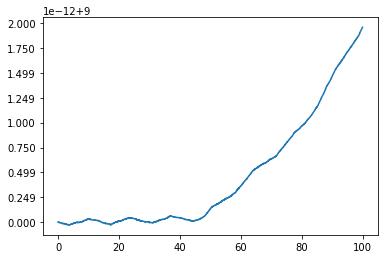

In [30]:
plt.plot(t, tr_ut, label="UT")

In [20]:
tr_ut[150]

8.999999999999975

In [75]:
JA_so  = np.einsum("ABCD, Ap, Bq, Cr, Ds -> pqrs", NN.I, NN.Ca, NN.Ca, NN.Ca, NN.Ca, optimize=True)
JAB_so = np.einsum("ABCD, Ap, Bq, Cr, Ds -> pqrs", NN.I, NN.Ca, NN.Ca, NN.Cb, NN.Cb, optimize=True)
JBA_so = np.einsum("ABCD, Ap, Bq, Cr, Ds -> pqrs", NN.I, NN.Cb, NN.Cb, NN.Ca, NN.Ca, optimize=True)
JB_so  = np.einsum("ABCD, Ap, Bq, Cr, Ds -> pqrs", NN.I, NN.Cb, NN.Cb, NN.Cb, NN.Cb, optimize=True)
KA_so  = np.einsum("ADCB, Ap, Bq, Cr, Ds -> pqrs", NN.I, NN.Ca, NN.Ca, NN.Ca, NN.Ca, optimize=True)
KB_so  = np.einsum("ADCB, Ap, Bq, Cr, Ds -> pqrs", NN.I, NN.Cb, NN.Cb, NN.Cb, NN.Cb, optimize=True)

def get_Πso(uhf):
    
    HA = np.einsum("AB, Ap, Bq -> pq", uhf.H, uhf.Ca, uhf.Ca, optimize=True)
    HB = np.einsum("AB, Ap, Bq -> pq", uhf.H, uhf.Cb, uhf.Cb, optimize=True)
    
    ΠAA  = np.einsum("ABCD, Ap, Bq, Cr, Ds -> pqrs", uhf.I, uhf.Ca, uhf.Ca, uhf.Ca, uhf.Ca, optimize=True) ## J
    ΠAA -= np.einsum("ADCB, Ap, Bq, Cr, Ds -> pqrs", uhf.I, uhf.Ca, uhf.Ca, uhf.Ca, uhf.Ca, optimize=True) ## K
    ΠBB  = np.einsum("ABCD, Ap, Bq, Cr, Ds -> pqrs", uhf.I, uhf.Cb, uhf.Cb, uhf.Cb, uhf.Cb, optimize=True) ## J
    ΠBB -= np.einsum("ADCB, Ap, Bq, Cr, Ds -> pqrs", uhf.I, uhf.Cb, uhf.Cb, uhf.Cb, uhf.Cb, optimize=True) ## K
    ΠAB  = np.einsum("ABCD, Ap, Bq, Cr, Ds -> pqrs", uhf.I, uhf.Ca, uhf.Ca, uhf.Cb, uhf.Cb, optimize=True)
    ΠBA  = np.einsum("ABCD, Ap, Bq, Cr, Ds -> pqrs", uhf.I, uhf.Cb, uhf.Cb, uhf.Ca, uhf.Ca, optimize=True)
    
    return ΠAA, ΠAB, ΠBA, ΠBB, HA, HB

ΠAA, ΠAB, ΠBA, ΠBB, HA, HB = get_Πso(OH)

FAA = HA + np.einsum("pqrs, rs -> pq", ΠAA, OH.Da_mo) + np.einsum("pqrs, rs -> pq", ΠAB, OH.Db_mo)
FBB = HB + np.einsum("pqrs, rs -> pq", ΠBB, OH.Db_mo) + np.einsum("pqrs, rs -> pq", ΠBA, OH.Da_mo)

In [4]:
def UT_old(DA_mo, DB_mo, hf, dt, dT, field, onoff=1.):
    
    tsteps = int(dT/dt)
    d_tmn = np.zeros( (tsteps, 3) )
    JA = np.empty((tsteps, DA_mo.shape[0], DA_mo.shape[1]), dtype=complex)
    JB = np.empty((tsteps, DB_mo.shape[0], DB_mo.shape[1]), dtype=complex)
    for step in range(tsteps):
        t = step * dt
    
        # get AO density matrices
        DA_ao, DB_ao = hf.getAO(DA_mo, DB_mo)
        
        # save to current
        d_tmn[step] = np.einsum('xmn, mn -> x', hf.D, ( DA_ao + DB_ao ).real )
        
        
        # compute FA_t, FB_t
        FA_ao, FB_ao = hf.get_UCFock(DA_ao, DB_ao) - onoff*np.einsum('xAB, x -> AB', hf.D, field.getEE(t) )
        FA, FB = hf.getMO(FA_ao, FB_ao)
        
        # compute propagators
        UA  = Expm( -1j*FA*dt ) #!!!
        UB  = Expm( -1j*FB*dt ) #!!!
        
        # full step forward
        DA_mo = (UA)@DA_mo@(UA.conj().T)
        DB_mo = (UB)@DB_mo@(UB.conj().T)

        JA[step] = DA_mo
        JB[step] = DB_mo
    return JA, JB

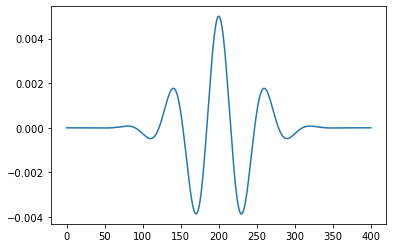

In [5]:
field4 = E_field()
field4.E0 = 5e-3
field4.ω  = 0.1 #4764
field4.Γ  = 100.
field4.t0  = 200
field4.vector = np.array([0.,1.,0.])

time = np.arange(0,400,0.02)
plt.plot(time, field4.getE(time))
plt.show()

In [114]:
JA, JB = UT_old(OH.Da_mo, OH.Db_mo, OH, 0.02, 400, field4, 1.)

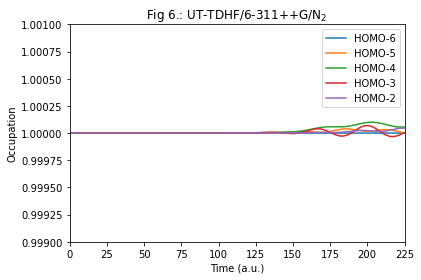

In [115]:
tt = np.arange(0, 400, 0.02)
plt.plot(tt, JA[:,0,0].real, label="HOMO-6")
plt.plot(tt, JA[:,1,1].real, label="HOMO-5")
plt.plot(tt, JA[:,2,2].real, label="HOMO-4")
plt.plot(tt, JA[:,3,3].real, label="HOMO-3")
plt.plot(tt, JA[:,4,4].real, label="HOMO-2")
#plt.plot(tt, JA[:,5,5].real, label="HOMO-1")
plt.xlim([0,225])
plt.ylim([0.999,1.001])
#plt.ylim([1-1e-12, 1+1e-12])
plt.title("Fig 6.: UT-TDHF/6-311++G/N$_2$")
plt.xlabel("Time (a.u.)")
plt.ylabel("Occupation")
plt.legend()
plt.show()

In [12]:
Z_NN = np.array(["N", "N"])
R_NN = np.array([[ 0., 0., -0.60], [0., 0., 0.60]])

NN = pyscf_UHF()
NN.initialize(xyz=R_NN, Z=Z_NN, charge=0, basis="sto-3g")
NN.Calc()

NN.Cb = NN.Ca

JA, JB = UT_old(NN.Da_mo, NN.Db_mo, NN, 0.02, 1000, field4, 1.)

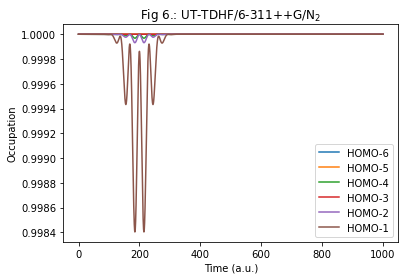

In [13]:
tt = np.arange(0, 1000, 0.02)
plt.plot(tt, JA[:,0,0].real, label="HOMO-6")
plt.plot(tt, JA[:,1,1].real, label="HOMO-5")
plt.plot(tt, JA[:,2,2].real, label="HOMO-4")
plt.plot(tt, JA[:,3,3].real, label="HOMO-3")
plt.plot(tt, JA[:,4,4].real, label="HOMO-2")
plt.plot(tt, JA[:,5,5].real, label="HOMO-1")
#plt.xlim([0,225])
#plt.ylim([1-1e-10, 1+1e-10])
plt.title("Fig 6.: UT-TDHF/6-311++G/N$_2$")
plt.xlabel("Time (a.u.)")
plt.ylabel("Occupation")
plt.legend()
plt.show()

In [77]:


def UT_oldnew(DA_mo, DB_mo, hf, dt, dT, field, onoff):
    
    def get_Πso(uhf):
    
        HA  = np.einsum("AB, Ap, Bq  ->  pq", uhf.H, uhf.Ca, uhf.Ca, optimize=True)
        HB  = np.einsum("AB, Ap, Bq  ->  pq", uhf.H, uhf.Cb, uhf.Cb, optimize=True)
        diA = np.einsum("xAB, Ap, Bq -> xpq", uhf.D, uhf.Ca, uhf.Ca, optimize=True)
        diB = np.einsum("xAB, Ap, Bq -> xpq", uhf.D, uhf.Cb, uhf.Cb, optimize=True)

        ΠAA  = np.einsum("ABCD, Ap, Bq, Cr, Ds -> pqrs", uhf.I, uhf.Ca, uhf.Ca, uhf.Ca, uhf.Ca, optimize=True) ## J
        ΠAA -= np.einsum("ADCB, Ap, Bq, Cr, Ds -> pqrs", uhf.I, uhf.Ca, uhf.Ca, uhf.Ca, uhf.Ca, optimize=True) ## K
        ΠBB  = np.einsum("ABCD, Ap, Bq, Cr, Ds -> pqrs", uhf.I, uhf.Cb, uhf.Cb, uhf.Cb, uhf.Cb, optimize=True) ## J
        ΠBB -= np.einsum("ADCB, Ap, Bq, Cr, Ds -> pqrs", uhf.I, uhf.Cb, uhf.Cb, uhf.Cb, uhf.Cb, optimize=True) ## K
        ΠAB  = np.einsum("ABCD, Ap, Bq, Cr, Ds -> pqrs", uhf.I, uhf.Ca, uhf.Ca, uhf.Cb, uhf.Cb, optimize=True)
        ΠBA  = np.einsum("ABCD, Ap, Bq, Cr, Ds -> pqrs", uhf.I, uhf.Cb, uhf.Cb, uhf.Ca, uhf.Ca, optimize=True)

        return ΠAA, ΠAB, ΠBA, ΠBB, HA, HB, diA, diB
    
    ΠAA, ΠAB, ΠBA, ΠBB, HA, HB, diA, diB = get_Πso(hf)
    
    tsteps = int(dT/dt)
    d_tmn = np.zeros( (tsteps, 3) )
    JA = np.empty((tsteps, DA_mo.shape[0], DA_mo.shape[1]), dtype=complex)
    JB = np.empty((tsteps, DB_mo.shape[0], DB_mo.shape[1]), dtype=complex)
    for step in range(tsteps):
        t = step * dt
        
        # save to current
        JA[step] = DA_mo
        JB[step] = DB_mo
        
        # compute FA_t, FB_t
        FA = HA + np.einsum("pqrs, rs -> pq", ΠAA, DA_mo) + np.einsum("pqrs, rs -> pq", ΠAB, DB_mo) - onoff * np.einsum("xpq, x -> pq", diA, field.getEE(t))
        FB = HB + np.einsum("pqrs, rs -> pq", ΠBB, DB_mo) + np.einsum("pqrs, rs -> pq", ΠBA, DA_mo) - onoff * np.einsum("xpq, x -> pq", diB, field.getEE(t))
        
        # compute propagators
        UA  = Expm( -1j*FA*dt ) #!!!
        UB  = Expm( -1j*FB*dt ) #!!!
        
        # full step forward
        DA_mo = (UA)@DA_mo@(UA.conj().T)
        DB_mo = (UB)@DB_mo@(UB.conj().T)

    return JA, JB

In [19]:
JA, JB = UT_oldnew(NN.Da_mo, NN.Db_mo, NN, 0.002, 1000, field4, 0.)

NameError: name 'UT_oldnew' is not defined

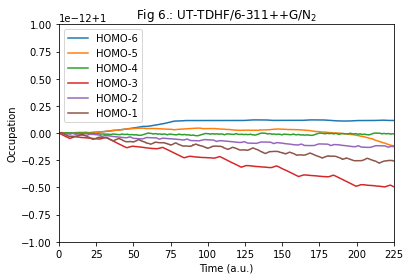

In [91]:
tt = np.arange(0, 10000, 0.02)
plt.plot(tt, JA[:,0,0].real, label="HOMO-6")
plt.plot(tt, JA[:,1,1].real, label="HOMO-5")
plt.plot(tt, JA[:,2,2].real, label="HOMO-4")
plt.plot(tt, JA[:,3,3].real, label="HOMO-3")
plt.plot(tt, JA[:,4,4].real, label="HOMO-2")
plt.plot(tt, JA[:,5,5].real, label="HOMO-1")
plt.xlim([0,225])
plt.ylim([1-1e-12, 1+1e-12])
plt.title("Fig 6.: UT-TDHF/6-311++G/N$_2$")
plt.xlabel("Time (a.u.)")
plt.ylabel("Occupation")
plt.legend()
plt.show()

In [9]:
Z_HH = np.array(['H', 'H'])
R_HH = np.array([[0.0000,   0.0000,    -0.44], [0.0000,   0.0000,   0.44]])

LiH = UHF()
LiH.Z   = Z_HH # Z_LiH #Z_HCN #Z_N2
LiH.xyz = R_HH #R_LiH #R_HCN #R_N2
mol = LiH.psi4string()
LiH.basis = "6-31g" ## 6-31g   sto3gg09

LiH.initialize(charge=0)
LiH.psi4UHF()
LiH.get_di()

field4 = E_field()
field4.E0 = 5e-2
field4.ω  = 0.1 #4764
field4.Γ  = 100.
field4.t0  = 200
field4.vector = np.array([0.,0.,1.])

JA, JB = UT_old(LiH.Da_mo, LiH.Db_mo, LiH, 0.002, 400, field4)

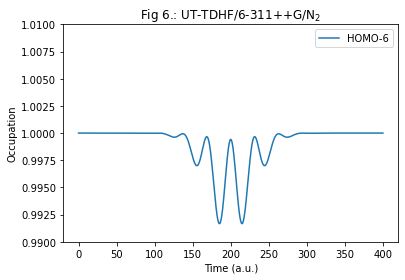

In [11]:
tt = np.arange(0, 400, 0.002)
plt.plot(tt, JA[:,0,0].real, label="HOMO-6")
#plt.plot(tt, JA[:,1,1].real, label="HOMO-5")
#plt.plot(tt, JA[:,2,2].real, label="HOMO-4")
#plt.plot(tt, JA[:,3,3].real, label="HOMO-3")
#plt.plot(tt, JA[:,4,4].real, label="HOMO-2")
#plt.plot(tt, JA[:,5,5].real, label="HOMO-1")
#plt.xlim([0,225])
plt.ylim([1-1e-2, 1+1e-2])
plt.title("Fig 6.: UT-TDHF/6-311++G/N$_2$")
plt.xlabel("Time (a.u.)")
plt.ylabel("Occupation")
plt.legend()
plt.show()

In [125]:
LiH.H

array([[-1.0383, -0.8029],
       [-0.8029, -1.0383]])